In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
file_path = Path("tsla.csv")
tsla_df = pd.read_csv(file_path, index_col="Date", parse_dates=True, infer_datetime_format=True)
tsla_df.drop(inplace=True, columns=["Down", "RSI(14)"])
tsla_df.dropna(inplace=True)
tsla_df.sort_index(inplace=True)
df = tsla_df.iloc[-1008:]
df.head(30)

,Open,High,Low,Close,Volume,Up
Date,,,,,,
2018-04-09,60.07400,61.90000,57.84200,57.932,51249025,51249025.0
2018-04-10,59.79400,61.42000,58.73600,60.940,55121295,55121295.0
2018-04-11,60.14806,61.79600,59.93200,60.186,37414725,37414725.0
2018-04-12,60.46400,60.79000,58.73600,58.816,38043845,38043845.0
2018-04-13,60.72000,60.78998,59.19600,60.068,36636115,36636115.0
2018-04-16,59.80000,59.93200,57.80200,58.242,31692440,31692440.0
2018-04-17,57.77400,58.43400,56.50200,57.538,35000115,35000115.0
2018-04-18,58.21600,60.04800,57.63200,58.670,32788500,32788500.0
2018-04-19,58.21600,60.20200,57.71000,60.016,30452995,30452995.0


In [21]:
from collections import deque
import random

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.90
        self.epsilon = 0.40
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.01

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))   
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                         inventory.append(self.trend[t])
                         starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [22]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

C:\Users\jerem\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:25: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
C:\Users\jerem\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.


epoch: 10, total rewards: 2447.887880.3, cost: 0.601902, total money: 12447.887880
epoch: 20, total rewards: 2339.541620.3, cost: 0.212961, total money: 12339.541620
epoch: 30, total rewards: 1772.587700.3, cost: 4.880972, total money: 11772.587700
epoch: 40, total rewards: 1483.893660.3, cost: 0.577298, total money: 11483.893660
epoch: 50, total rewards: 1808.259740.3, cost: 0.029057, total money: 11808.259740
epoch: 60, total rewards: 1796.301600.3, cost: 0.024964, total money: 11796.301600
epoch: 70, total rewards: 1966.627800.3, cost: 0.058250, total money: 11966.627800
epoch: 80, total rewards: 1711.901600.3, cost: 0.015631, total money: 11711.901600
epoch: 90, total rewards: 2197.961640.3, cost: 0.004928, total money: 12197.961640
epoch: 100, total rewards: 2453.455520.3, cost: 0.007234, total money: 12453.455520
epoch: 110, total rewards: 2320.007520.3, cost: 0.006518, total money: 12320.007520
epoch: 120, total rewards: 2256.075520.3, cost: 0.004199, total money: 12256.075520
e

In [23]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 10: buy 1 unit at price 56.674000, total balance 9943.326000
day 12, sell 1 unit at price 56.138000, investment -0.945760 %, total balance 9999.464000,
day 25: buy 1 unit at price 58.394000, total balance 9941.070000
day 27, sell 1 unit at price 57.296000, investment -1.880330 %, total balance 9998.366000,
day 32: buy 1 unit at price 55.814000, total balance 9942.552000
day 33, sell 1 unit at price 55.570000, investment -0.437166 %, total balance 9998.122000,
day 34: buy 1 unit at price 55.770000, total balance 9942.352000
day 35, sell 1 unit at price 56.752000, investment 1.760803 %, total balance 9999.104000,
day 39: buy 1 unit at price 59.348000, total balance 9939.756000
day 40: buy 1 unit at price 58.226000, total balance 9881.530000
day 42, sell 1 unit at price 63.218000, investment 6.520860 %, total balance 9944.748000,
day 44: buy 1 unit at price 66.420000, total balance 9878.328000
day 46, sell 1 unit at price 68.956000, investment 18.428194 %, total balance 9947.284000,
d

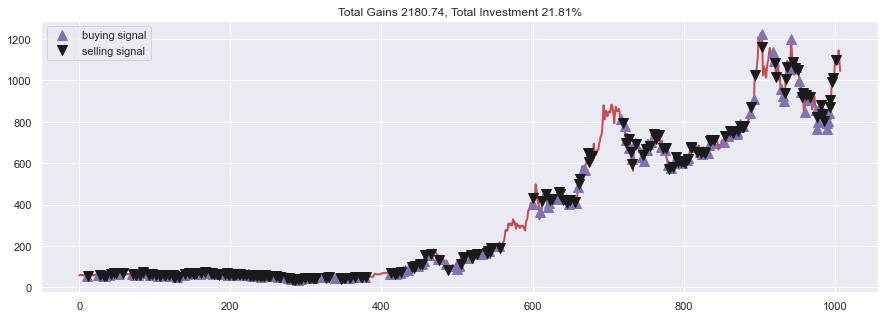

In [24]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('Total Gains %.2f, Total Investment %.2f%%'%(total_gains, invest))
plt.legend()
plt.show()